In [ ]:
# import CurvyCUSIPs as cc
# from CurvyCUSIPs 

In [14]:
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import statsmodels.api as sm

import scipy.interpolate
import os
from dotenv import dotenv_values
env_path = os.path.join(os.getcwd(), "../.env")
print(env_path)
config = dotenv_values(env_path)

import nest_asyncio
nest_asyncio.apply()

import matplotlib.pylab as pylab
params = {
    "legend.fontsize": "x-large",
    "axes.labelsize": "x-large",
    "axes.titlesize": "x-large",
    "xtick.labelsize": "x-large",
    "ytick.labelsize": "x-large",
}
pylab.rcParams.update(params)
sns.set(style="whitegrid", palette="dark")
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)

%load_ext autoreload
%autoreload 2

c:\Users\chris\Project Bond King\Curvy-CUSIPs\notebooks\../.env


In [2]:
curve_data_fetcher = CurveDataFetcher(use_ust_issue_date=True, fred_api_key=config["FRED_API_KEY"], debug_verbose=True)

2024-11-07 14:08:04,536 - DataFetcher.base - DEBUG - UST Auctions - Number of Links to Fetch: 2
2024-11-07 14:08:04,537 - DataFetcher.base - DEBUG - UST Auctions - Links: ['https://api.fiscaldata.treasury.gov/services/api/fiscal_service/v1/accounting/od/auctions_query?page[number]=1&page[size]=10000', 'https://api.fiscaldata.treasury.gov/services/api/fiscal_service/v1/accounting/od/auctions_query?page[number]=2&page[size]=10000']


In [ ]:
start_date = datetime(2024, 10, 18)
end_date = datetime(2024, 11, 6)

In [ ]:
ct_yields_df = curve_data_fetcher.fedinvest_data_fetcher.get_historical_ct_yields(start_date=start_date, end_date=end_date)
ct_yields_df

,Date,CT1M,CT2M,CT3M,CT4M,CT6M,CT1,CT2,CT3,CT5,CT7,CT10,CT20,CT30
0,2024-10-18,4.703479,4.680224,4.580141,4.533609,4.403849,4.181562,3.953653,3.863391,3.877713,3.967187,4.077386,4.444782,4.383998
1,2024-10-21,4.702861,4.669494,4.579560,4.543325,4.434627,4.235190,4.022159,3.953014,3.977253,4.072822,4.180159,4.546358,4.486912
2,2024-10-22,4.692200,4.668887,4.568758,4.542749,4.434082,4.234692,4.039827,3.975500,3.998837,4.099469,4.200090,4.556389,4.490846
3,2024-10-23,4.685807,4.662380,4.568181,4.546193,4.443971,4.266673,4.074617,4.031857,4.049047,4.142153,4.236031,4.589054,4.512546
4,2024-10-24,4.685201,4.641499,4.557390,4.535323,4.432990,4.255341,4.075329,4.020638,4.027845,4.115694,4.208171,4.548939,4.469260
5,2024-10-25,4.469910,4.546325,4.486513,4.492925,4.420097,4.273141,4.146195,4.088768,4.107447,4.190853,4.276347,4.619478,4.526426
6,2024-10-28,4.895851,4.734397,4.623056,4.594847,4.491743,4.298976,4.112597,4.054864,4.064636,4.153605,4.244365,4.596771,4.512561
7,2024-10-29,4.457009,4.521470,4.453881,4.470698,4.408344,4.250486,4.165077,4.134471,4.144007,4.207273,4.280516,4.606901,4.492829
8,2024-10-30,4.866661,4.718346,4.592136,4.564853,4.459419,4.276331,4.131403,4.077765,4.108288,4.186019,4.276578,4.622115,4.522471
9,2024-10-31,4.624807,4.611093,4.485922,4.494150,4.412125,4.251823,4.166780,4.123401,4.151822,4.218366,4.272640,4.581754,4.465356


In [90]:
def interp_func(x, y, x_new):
    f = scipy.interpolate.interp1d(x, y, kind="linear", fill_value="extrapolate", bounds_error=False)
    return f(x_new)


sofr_swaps_df = curve_data_fetcher.bbg_sef_fetcher.get_usd_sofr_swaps_historical_term_structures(
    start_date=start_date, end_date=end_date, liquid_tenors=True, interp_extrap_strat=interp_func
)
sofr_swaps_df

,Date,USD SWAP VS SOFR 1M,USD SWAP VS SOFR 2M,USD SWAP VS SOFR 3M,USD SWAP VS SOFR 4M,USD SWAP VS SOFR 6M,USD SWAP VS SOFR 9M,USD SWAP VS SOFR 1Y,USD SWAP VS SOFR 18M,USD SWAP VS SOFR 2Y,...,USD SWAP VS SOFR 11Y,USD SWAP VS SOFR 12Y,USD SWAP VS SOFR 15Y,USD SWAP VS SOFR 20Y,USD SWAP VS SOFR 25Y,USD SWAP VS SOFR 30Y,USD SWAP VS SOFR 35Y,USD SWAP VS SOFR 40Y,USD SWAP VS SOFR 45Y,USD SWAP VS SOFR 50Y
0,2024-10-18,4.75600,4.695600,4.62890,4.326767,3.72250,4.25950,4.11191,3.88050,3.75453,...,3.62032,3.64338,3.69130,3.69420,3.636800,3.57150,3.483100,3.39897,3.314840,3.23071
1,2024-10-21,4.75090,4.693600,4.63664,4.559610,4.46530,4.31050,4.16355,3.93622,3.84203,...,3.72164,3.75801,3.79070,3.81390,3.740840,3.68153,3.572780,3.46403,3.355280,3.24653
2,2024-10-22,4.73850,4.680410,4.62563,4.571653,4.46370,4.31195,4.18466,3.95250,3.87020,...,3.74574,3.76423,3.80150,3.80744,3.759200,3.67730,3.587910,3.49852,3.409130,3.31974
3,2024-10-23,4.74284,4.680035,4.61723,4.567290,4.44580,4.31939,4.17290,3.95745,3.86814,...,3.77193,3.79429,3.81604,3.83650,3.759090,3.68755,3.603070,3.51859,3.434110,3.34963
4,2024-10-24,4.71380,4.657270,4.58940,4.534967,4.42610,4.28700,4.14980,3.95230,3.86750,...,3.73555,3.75941,3.79790,3.79000,3.730400,3.62493,3.519460,3.41399,3.308520,3.20305
5,2024-10-25,4.73550,4.663695,4.59189,4.524200,4.41550,4.26150,4.16655,3.98156,3.89168,...,3.70899,3.74607,3.80310,3.83215,3.753985,3.67582,3.597655,3.51949,3.441325,3.36316
6,2024-10-28,4.69850,4.630680,4.20500,4.277890,4.42367,4.28387,4.17338,3.99420,3.91013,...,3.79594,3.81835,3.85300,3.84111,3.801000,3.69115,3.612600,3.53405,3.455500,3.37695
7,2024-10-29,4.68150,4.633400,4.57850,4.519227,4.40068,4.25263,4.14221,3.97640,3.86910,...,3.83881,3.78971,3.86350,3.81131,3.744960,3.66441,3.630700,3.50723,3.383760,3.26029
8,2024-10-30,4.67260,4.623000,4.56850,4.511500,4.42500,4.29709,4.19530,4.01115,3.95244,...,3.76140,3.81150,3.83500,3.83776,3.757630,3.66669,3.572520,3.47835,3.384180,3.29001
9,2024-10-31,4.64948,4.604000,4.03640,4.507600,4.41100,4.28343,4.19086,4.00650,3.94560,...,3.78678,3.79446,3.79613,3.80132,3.749280,3.63948,3.557620,3.47576,3.393900,3.31204


In [91]:
curve_data_fetcher.bbg_sef_fetcher.calc_sofr_swap_spreads(ct_yields_df=ct_yields_df, sofr_swaps_df=sofr_swaps_df)

,USD SWAP VS SOFR 1M Spread,USD SWAP VS SOFR 2M Spread,USD SWAP VS SOFR 3M Spread,USD SWAP VS SOFR 4M Spread,USD SWAP VS SOFR 6M Spread,USD SWAP VS SOFR 1Y Spread,USD SWAP VS SOFR 2Y Spread,USD SWAP VS SOFR 3Y Spread,USD SWAP VS SOFR 5Y Spread,USD SWAP VS SOFR 7Y Spread,USD SWAP VS SOFR 10Y Spread,USD SWAP VS SOFR 20Y Spread,USD SWAP VS SOFR 30Y Spread
0,0.052521,0.015376,0.048759,-0.206843,-0.681349,-0.069652,-0.199123,-0.235971,-0.320713,-0.403037,-0.461396,-0.750582,-0.812498
1,0.048039,0.024106,0.057080,0.016285,0.030673,-0.071640,-0.180129,-0.225014,-0.296023,-0.395382,-0.443519,-0.732458,-0.805382
2,0.046300,0.011523,0.056872,0.028904,0.029618,-0.050032,-0.169627,-0.216690,-0.289387,-0.380629,-0.452680,-0.748949,-0.813546
3,0.057033,0.017655,0.049049,0.021097,0.001829,-0.093773,-0.206477,-0.265357,-0.341047,-0.408153,-0.487831,-0.752554,-0.824996
4,0.028599,0.015771,0.032010,-0.000356,-0.006890,-0.105541,-0.207829,-0.268688,-0.344825,-0.428494,-0.496481,-0.758939,-0.844330
5,0.265590,0.117370,0.105377,0.031275,-0.004597,-0.106591,-0.254515,-0.287568,-0.372947,-0.461453,-0.515647,-0.787328,-0.850606
6,-0.197351,-0.103717,-0.418056,-0.316957,-0.068073,-0.125596,-0.202467,-0.232294,-0.306136,-0.392605,-0.463225,-0.755661,-0.821411
7,0.224491,0.111930,0.124619,0.048528,-0.007664,-0.108276,-0.295977,-0.316871,-0.424807,-0.478903,-0.525516,-0.795591,-0.828419
8,-0.194061,-0.095346,-0.023636,-0.053353,-0.034419,-0.081031,-0.178963,-0.204125,-0.313848,-0.405519,-0.485548,-0.784355,-0.855781
9,0.024673,-0.007093,-0.449522,0.013450,-0.001125,-0.060963,-0.221180,-0.262901,-0.367452,-0.457366,-0.496770,-0.780434,-0.825876


In [23]:
from_date = datetime(2003, 1, 1)
end_date = datetime(2024, 11, 6)

In [24]:
iron_steel_index_df = curve_data_fetcher.yf_data_fetcher.fetch_yf_legacy(ticker="^DJUSST", from_date=from_date, to_date=end_date)
iron_steel_index_df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2003-01-02,60.470001,62.560001,60.160000,61.810001,61.810001,27200
1,2003-01-03,61.830002,61.840000,61.310001,61.689999,61.689999,21000
2,2003-01-06,61.689999,63.320000,61.480000,62.990002,62.990002,24100
3,2003-01-07,62.990002,63.970001,62.580002,63.119999,63.119999,23600
4,2003-01-08,63.130001,63.169998,60.639999,60.830002,60.830002,25500
...,...,...,...,...,...,...,...
5494,2024-10-30,566.969971,574.169983,558.179993,558.369995,558.369995,19217600
5495,2024-10-31,557.900024,561.630005,550.719971,551.380005,551.380005,22829800
5496,2024-11-01,552.250000,559.809998,552.030029,558.000000,558.000000,21134400
5497,2024-11-04,557.979980,562.289978,554.760010,556.090027,556.090027,25454500


In [25]:
vale_df = curve_data_fetcher.yf_data_fetcher.fetch_yf_legacy(ticker="VALE", from_date=from_date, to_date=end_date)
vale_df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2003-01-02,2.416667,2.429167,2.405000,2.408333,0.864027,1266000
1,2003-01-03,2.408333,2.415833,2.385833,2.408333,0.864027,3025200
2,2003-01-06,2.433333,2.454167,2.415000,2.416667,0.867017,2779200
3,2003-01-07,2.412500,2.435833,2.408333,2.429167,0.871502,2565600
4,2003-01-08,2.412500,2.425000,2.333333,2.345833,0.841604,3720000
...,...,...,...,...,...,...,...
5494,2024-10-30,10.800000,10.850000,10.740000,10.810000,10.810000,31388800
5495,2024-10-31,10.830000,10.830000,10.680000,10.700000,10.700000,16824900
5496,2024-11-01,10.730000,10.780000,10.550000,10.600000,10.600000,20467700
5497,2024-11-04,10.760000,10.910000,10.740000,10.780000,10.780000,20468800


                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.384
Model:                            OLS   Adj. R-squared:                  0.384
Method:                 Least Squares   F-statistic:                     3421.
Date:                Thu, 07 Nov 2024   Prob (F-statistic):               0.00
Time:                        14:14:04   Log-Likelihood:                -2292.1
No. Observations:                5498   AIC:                             4588.
Df Residuals:                    5496   BIC:                             4601.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0023      0.005     -0.472      0.6

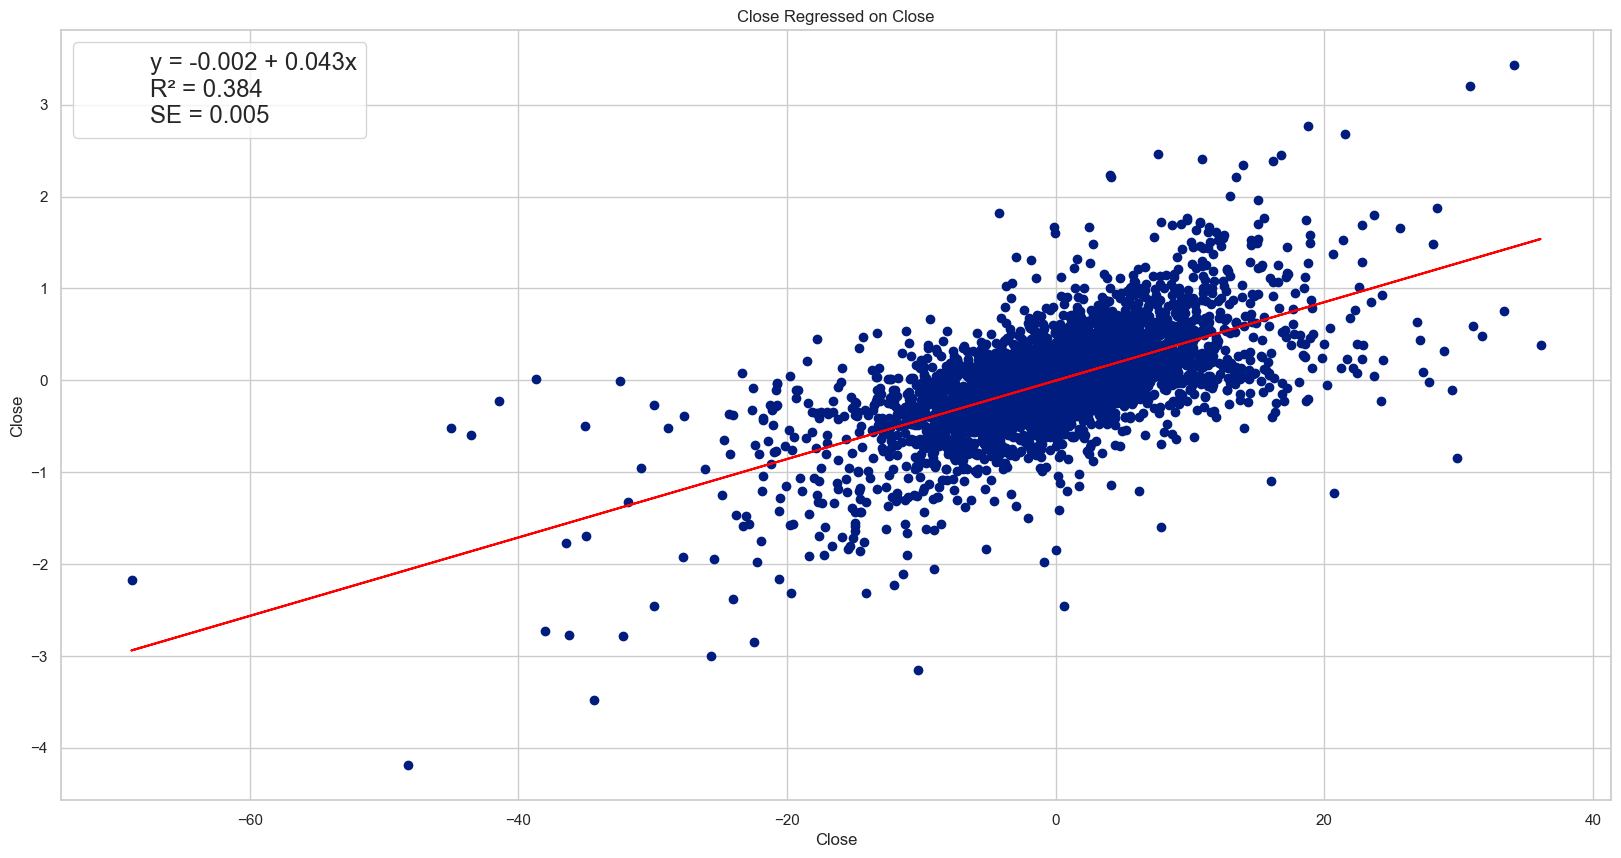

In [26]:
run_basic_linear_regression(x_series=iron_steel_index_df["Close"].diff().dropna(), y_series=vale_df["Close"].diff().dropna())